In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

In [24]:
digits = [3, 5, 8, 9]
n_px = 16
train_size = 10000
test_size = 2000
batch_size = 32
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [25]:
def get_dataset(digits=[3, 5], n_px=8, train_size=1000, test_size=200):
    # Load raw data (uint8 [0-255])
    mnist_train = datasets.MNIST(root='./data', train=True, download=True)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True)

    # Helper: filter, sample, normalize, resize
    def prepare(data, targets, digits, size, n_px):
        # Filter by class
        mask = torch.zeros_like(targets, dtype=torch.bool)
        for d in digits:
            mask |= (targets == d)
        data_f = data[mask]
        targ_f = targets[mask]

        # Sample 'size' examples
        idx = torch.randperm(len(data_f))[:size]
        imgs = data_f[idx].unsqueeze(1).float() / 255.0  # [size,1,28,28]
        labs = targ_f[idx]

        # Resize to n_px x n_px
        imgs_resized = F.interpolate(imgs, size=(n_px, n_px), mode='bilinear', align_corners=False)
        # Map labels to 0..len(digits)-1
        labs_mapped = torch.tensor([digits.index(int(l)) for l in labs])
        return imgs_resized, labs_mapped

    x_train, y_train = prepare(mnist_train.data, mnist_train.targets, digits, train_size, n_px)
    x_test, y_test   = prepare(mnist_test.data, mnist_test.targets,   digits, test_size,  n_px)
    return (x_train, y_train), (x_test, y_test)

In [26]:
def visualise_data(digits, x_data, y_data, title_prefix=""):
    # # x_data: [N,1,H,W], y_data: [N]
    # n = len(digits)
    # fig, axes = plt.subplots(1, n, figsize=(10, 2))
    # for i, ax in enumerate(axes):
    #     ax.imshow(x_data[i].squeeze(), cmap='gray')
    #     ax.set_title(f"{title_prefix} {digits[y_data[i]]}")
    #     ax.axis('off')
    # plt.tight_layout()
    # plt.show()
    # n = len(digits)
    # fig, axes = plt.subplots(1, n, figsize=(10, 2))
    # for i in range(n):
    #     # find first sample of class i
    #     idx = (y_data == i).nonzero(as_tuple=True)[0]
    #     if idx.numel() > 0:
    #         img = x_data[idx[0]].cpu().squeeze()
    #         axes[i].imshow(img, cmap='gray')
    #         axes[i].set_title(f"{title_prefix}{digits[i]}")
    #     axes[i].axis('off')
    # plt.tight_layout()
    # plt.show()
    n = len(digits)
    fig, axes = plt.subplots(1, n, figsize=(10, 2))
    for i in range(n):
        idx = (y_data == i).nonzero(as_tuple=True)[0]
        if idx.numel() > 0:
            img = x_data[idx[0]].cpu().squeeze()
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f"{title_prefix}{digits[i]}")
        else:
            axes[i].imshow(torch.zeros((n_px, n_px)), cmap='gray')
            axes[i].set_title(f"{title_prefix}{digits[i]}\n(Not Found)")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

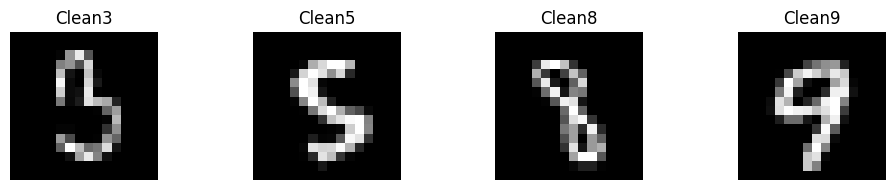

In [27]:
# Load and prepare dataset
(x_train, y_train), (x_test, y_test) = get_dataset(digits=digits, n_px=n_px, train_size=train_size, test_size=test_size)
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(x_test,  y_test),  batch_size=batch_size)

# Select test subset for visualization and PGD
x_vis = x_test[:1000].to(device)
y_vis = y_test[:1000].to(device)
visualise_data(digits, x_vis.cpu(), y_vis.cpu(), title_prefix="Clean")

In [28]:
# --- MODELS ---
class ClassicalCNN(nn.Module):
    def __init__(self, n_px, n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) # can lower output chanels to 8
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * (n_px // 2) * (n_px // 2), n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.fc1(x), dim=1)

class SimpleFCNN(nn.Module):
    def __init__(self, n_px, n_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(n_px * n_px, 32)
        self.fc2 = nn.Linear(32, n_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [29]:
from torchsummary import summary

model = SimpleFCNN(n_px=16, n_classes=4).to(device)
summary(model,input_size=(1,16,16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 256]               0
            Linear-2                   [-1, 32]           8,224
            Linear-3                    [-1, 4]             132
Total params: 8,356
Trainable params: 8,356
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [30]:
# --- TRAIN / TEST ---
def train(model, loader, optimizer, criterion):
    model.train()
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        loss = criterion(model(data), target)
        loss.backward()
        optimizer.step()


def test(model, loader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            pred = model(data).argmax(dim=1)
            total += target.size(0)
            correct += pred.eq(target).sum().item()
    return correct / total

In [31]:
# --- PGD ATTACK ---
def PGD(model, x, y, epsilon=0.1, alpha=0.01, num_iter=1000):
    x_orig = x.detach()
    delta = torch.zeros_like(x_orig, requires_grad=True)
    for _ in range(num_iter):
        output = model(x_orig + delta)
        loss = nn.NLLLoss()(output, y)
        loss.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    adv_x = torch.clamp(x_orig + delta.detach(), 0, 1)
    return adv_x

Training CNN model...
CNN Clean Test Acc: 0.9875
CNN Adversarial (PGD) Acc on subset: 0.2790


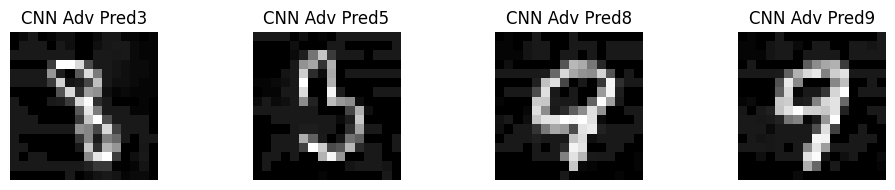

Training FC model...
FC Clean Test Acc: 0.9585
FC Adversarial (PGD) Acc on subset: 0.0340


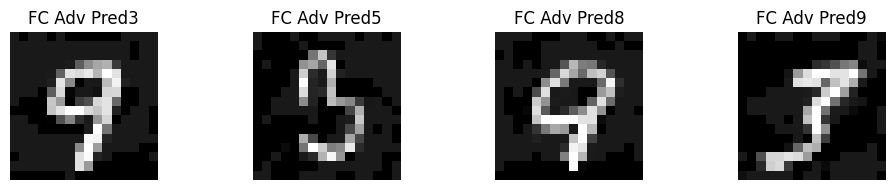


Time elapsed: 26.386300086975098 s.


In [34]:
import time
t = time.time()

# --- RUN (Compare CNN vs FCNN) ---
n_classes = len(digits)

trained_models = {}
results = {}
for name, net in [("CNN", ClassicalCNN(n_px, n_classes)), ("FC", SimpleFCNN(n_px, n_classes))]:
    model = net.to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)
    crit = nn.NLLLoss()

    print(f"Training {name} model...")
    for epoch in range(epochs):
        train(model, train_loader, opt, crit)
    acc_clean = test(model, test_loader)
    print(f"{name} Clean Test Acc: {acc_clean:.4f}")

    adv = PGD(model, x_vis, y_vis, epsilon=0.1)
    acc_adv = (model(adv).argmax(1) == y_vis).float().mean().item()
    print(f"{name} Adversarial (PGD) Acc on subset: {acc_adv:.4f}")

    # Visualize a few
    visualise_data(digits, adv.cpu(), model(adv).argmax(1).cpu(), title_prefix=f"{name} Adv Pred")
    results[name] = (acc_clean, acc_adv)

    trained_models[name] = model

elapsed = time.time() - t
print(f"\nTime elapsed: {elapsed} s.")

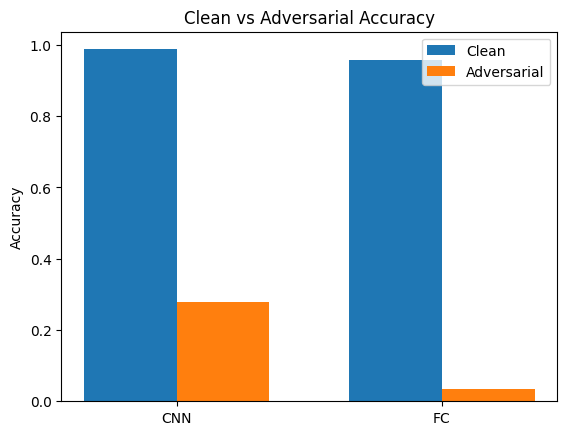

In [35]:
# Summary Plot
labels = list(results.keys())
clean_vals = [results[k][0] for k in labels]
adv_vals   = [results[k][1] for k in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, clean_vals, width, label='Clean')
ax.bar(x + width/2, adv_vals,   width, label='Adversarial')
ax.set_ylabel('Accuracy')
ax.set_title('Clean vs Adversarial Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

Epsilon: 0.00 	Adversarial Accuracy: 0.9600
Epsilon: 0.02 	Adversarial Accuracy: 0.8400
Epsilon: 0.04 	Adversarial Accuracy: 0.5360
Epsilon: 0.07 	Adversarial Accuracy: 0.2180
Epsilon: 0.09 	Adversarial Accuracy: 0.0890
Epsilon: 0.11 	Adversarial Accuracy: 0.0230
Epsilon: 0.13 	Adversarial Accuracy: 0.0060
Epsilon: 0.16 	Adversarial Accuracy: 0.0030
Epsilon: 0.18 	Adversarial Accuracy: 0.0020
Epsilon: 0.20 	Adversarial Accuracy: 0.0000


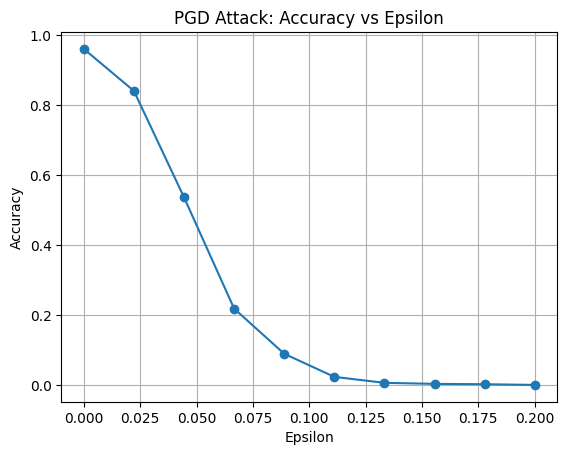

In [20]:
epsilons = np.linspace(0, 0.2, 10)
accuracies = []

for eps in epsilons:
    adv = PGD(model, x_vis, y_vis, epsilon=eps)
    acc_adv = (model(adv).argmax(1) == y_vis).float().mean().item()
    print(f"Epsilon: {eps:.2f} \tAdversarial Accuracy: {acc_adv:.4f}")
    accuracies.append(acc_adv)

# Plot
import matplotlib.pyplot as plt
plt.plot(epsilons, accuracies, 'o-')
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title("PGD Attack: Accuracy vs Epsilon")
plt.grid(True)
plt.show()



Evaluating CNN model...
Epsilon: 0.00 	Adv Accuracy: 0.9910
Epsilon: 0.01 	Adv Accuracy: 0.9820
Epsilon: 0.05 	Adv Accuracy: 0.8550
Epsilon: 0.10 	Adv Accuracy: 0.3330
Epsilon: 0.15 	Adv Accuracy: 0.0240
Epsilon: 0.20 	Adv Accuracy: 0.0010

Evaluating FC model...
Epsilon: 0.00 	Adv Accuracy: 0.9650
Epsilon: 0.01 	Adv Accuracy: 0.9270
Epsilon: 0.05 	Adv Accuracy: 0.4110
Epsilon: 0.10 	Adv Accuracy: 0.0500
Epsilon: 0.15 	Adv Accuracy: 0.0040
Epsilon: 0.20 	Adv Accuracy: 0.0000


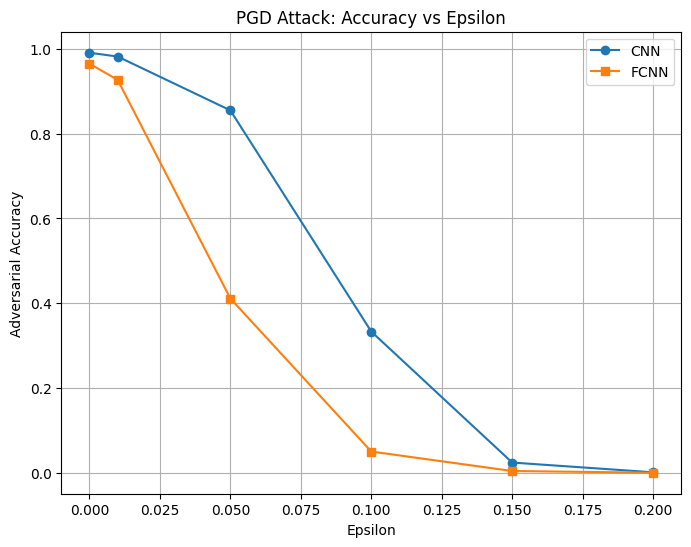

In [22]:
epsilons = [0, 0.01, 0.05, 0.1, 0.15, 0.2]
results = {"CNN": [], "FC": []}

for name, net in [("CNN", ClassicalCNN(n_px, n_classes)), ("FC", SimpleFCNN(n_px, n_classes))]:
    print(f"\nEvaluating {name} model...")
    model = net.to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)
    crit = nn.NLLLoss()

    # Train the model
    for epoch in range(epochs):
        train(model, train_loader, opt, crit)

    # Evaluate at different epsilons
    accs = []
    for eps in epsilons:
        adv = PGD(model, x_vis, y_vis, epsilon=eps)
        acc_adv = (model(adv).argmax(1) == y_vis).float().mean().item()
        print(f"Epsilon: {eps:.2f} \tAdv Accuracy: {acc_adv:.4f}")
        accs.append(acc_adv)
    results[name] = accs

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(epsilons, results["CNN"], 'o-', label="CNN")
plt.plot(epsilons, results["FC"], 's-', label="FCNN")
plt.xlabel("Epsilon")
plt.ylabel("Adversarial Accuracy")
plt.title("PGD Attack: Accuracy vs Epsilon")
plt.legend()
plt.grid(True)
plt.show()



Evaluating CNN model on adversarial examples...
Epsilon: 0.00 	Adv Accuracy: 0.9890
Epsilon: 0.02 	Adv Accuracy: 0.9520
Epsilon: 0.04 	Adv Accuracy: 0.8680
Epsilon: 0.07 	Adv Accuracy: 0.6850
Epsilon: 0.09 	Adv Accuracy: 0.4090
Epsilon: 0.11 	Adv Accuracy: 0.1720
Epsilon: 0.13 	Adv Accuracy: 0.0620
Epsilon: 0.16 	Adv Accuracy: 0.0100
Epsilon: 0.18 	Adv Accuracy: 0.0030
Epsilon: 0.20 	Adv Accuracy: 0.0000

Evaluating FC model on adversarial examples...
Epsilon: 0.00 	Adv Accuracy: 0.9600
Epsilon: 0.02 	Adv Accuracy: 0.8160
Epsilon: 0.04 	Adv Accuracy: 0.4620
Epsilon: 0.07 	Adv Accuracy: 0.1820
Epsilon: 0.09 	Adv Accuracy: 0.0710
Epsilon: 0.11 	Adv Accuracy: 0.0180
Epsilon: 0.13 	Adv Accuracy: 0.0060
Epsilon: 0.16 	Adv Accuracy: 0.0010
Epsilon: 0.18 	Adv Accuracy: 0.0000
Epsilon: 0.20 	Adv Accuracy: 0.0000


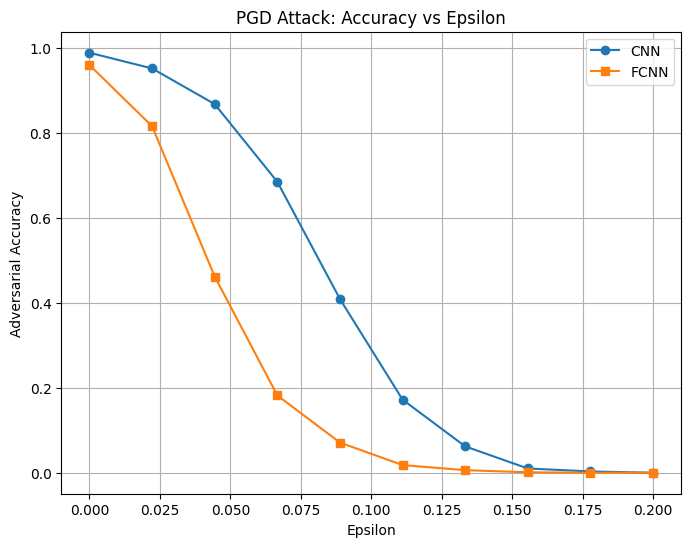

In [37]:
# Assuming 'model' holds the last trained model, but you trained both CNN and FCNN earlier
# Let's assume you stored them in a dictionary after training, like this:
# trained_models = {"CNN": cnn_model, "FC": fcnn_model}

epsilons = np.linspace(0, 0.2, 10)
results = {"CNN": [], "FC": []}

for name, model in trained_models.items():
    print(f"\nEvaluating {name} model on adversarial examples...")
    model.eval()
    accs = []
    for eps in epsilons:
        adv = PGD(model, x_vis, y_vis, epsilon=eps)
        acc_adv = (model(adv).argmax(1) == y_vis).float().mean().item()
        print(f"Epsilon: {eps:.2f} \tAdv Accuracy: {acc_adv:.4f}")
        accs.append(acc_adv)
    results[name] = accs

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(epsilons, results["CNN"], 'o-', label="CNN")
plt.plot(epsilons, results["FC"], 's-', label="FCNN")
plt.xlabel("Epsilon")
plt.ylabel("Adversarial Accuracy")
plt.title("PGD Attack: Accuracy vs Epsilon")
plt.legend()
plt.grid(True)
plt.show()
